In [24]:
using Plots, PlotThemes, HTTP, Gumbo, DataInterpolations
set_theme(:juno)

# Upper Atmosphere Modelling
Using data from: http://www.braeunig.us/space/atmos.htm

In [5]:
r = HTTP.request("GET", "http://www.braeunig.us/space/atmos.htm")
r.status

200

In [6]:
# parsing and getting body
r_parsed = parsehtml(String(r.body))
body = r_parsed.root[2];

In [14]:
# table 2, MSISE-90 Model with mean solar activity
alts_t2, densities_t2 = Vector{Float64}(), Vector{Float64}()

for i in 10:50
    row = body[2][1][3][2][1][1][i]

    push!(alts_t2, parse(Float64, row[1][1][1].text))
    push!(densities_t2, parse(Float64, row[7][1][1].text))
end

In [57]:
# table 3 data
alts_t3, densities_t3 = Vector{Float64}(), Vector{Float64}()

for i in 6:22
    row = body[2][1][4][2][1][1][i]

    push!(alts_t3, parse(Float64, row[1][1][1].text))
    push!(densities_t3, parse(Float64, row[3][1][1].text))
end

In [72]:
orbit_alts = LinRange(100,900,500)
density_interp = QuadraticInterpolation(densities_t2, alts_t2);

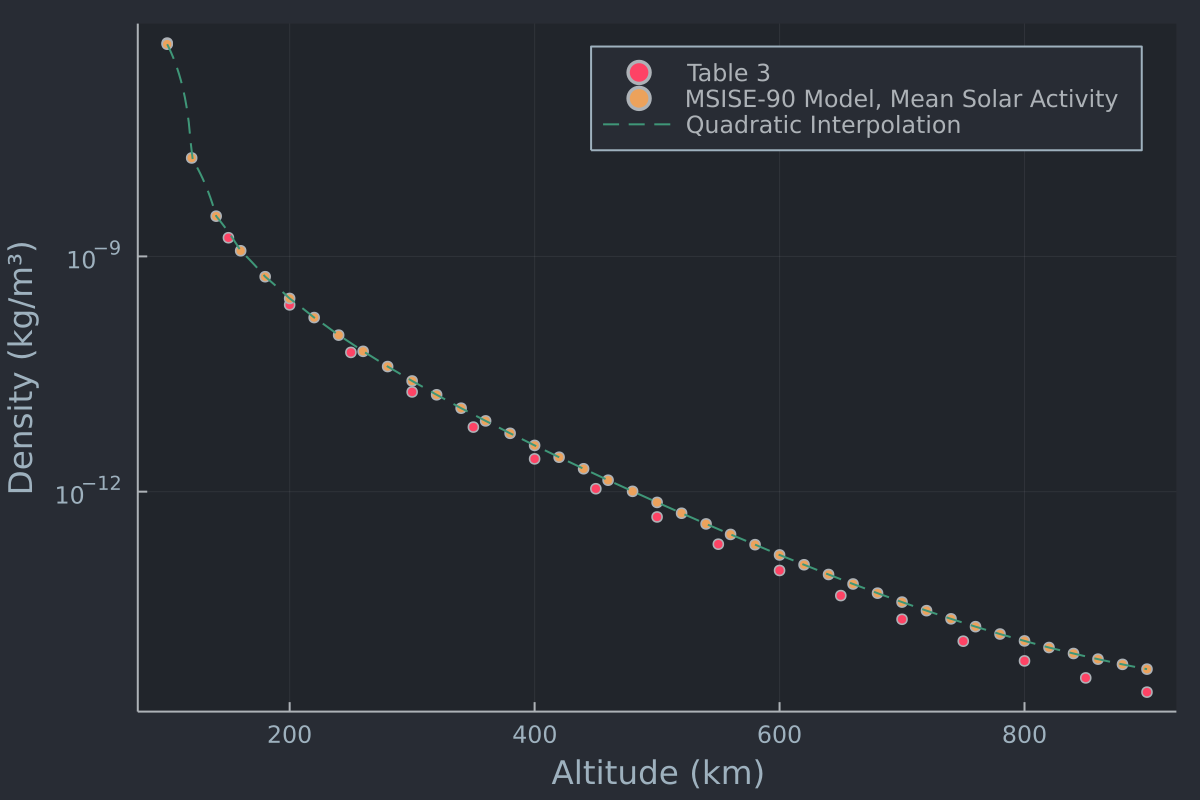

In [123]:
scatter(
    alts_t3, densities_t3, 
    yaxis=:log,
    ylabel="Density (kg/m³)",
    xlabel="Altitude (km)",
    label="Table 3",
    markersize=3,
    format=:png,
    dpi=200
)

scatter!(alts_t2, densities_t2, label="MSISE-90 Model, Mean Solar Activity", markersize=3)

plot!(orbit_alts, density_interp.(orbit_alts), linestyle=:dash, label="Quadratic Interpolation")

# Aerodynamic Drag Modelling

In [75]:
# defining constants
A_s = 2.287
Cd = 2.25
Cg = 0.2595
Cp = 0.1949

re = 6378
μ = 398600;

In [89]:
# gravity gradient torques
J = [
    66.4151 0 0 
    0 66.4151 0
    0 0 116.163
]

Tg = (3*μ./((re .+ orbit_alts).^3)) * (J[3,3] - J[2,2]) * sin(2 * deg2rad(1));

In [93]:
# solar pressure torques
q = 0.8
i = deg2rad(0)

Tsp = (Cg - Cp) * (1367 / 3e8) * A_s * (1 + q) * cos(i)

1.2117651204000004e-6

In [100]:
# magnetic torques
#T_magnetic = D * 2 * 7.96e15 / r_orbit^3
D = 1
Tm = D * 2 * 7.96e15 ./ ((re .+ orbit_alts).*1e3).^3;

In [103]:
# aerodynamic torques
orbital_velocities = sqrt.(μ ./ (re .+ orbit_alts))*1e3
Ta = 0.5.*density_interp.(orbit_alts).*Cd.*A_s.*(orbital_velocities.^2).*(Cg - Cp);

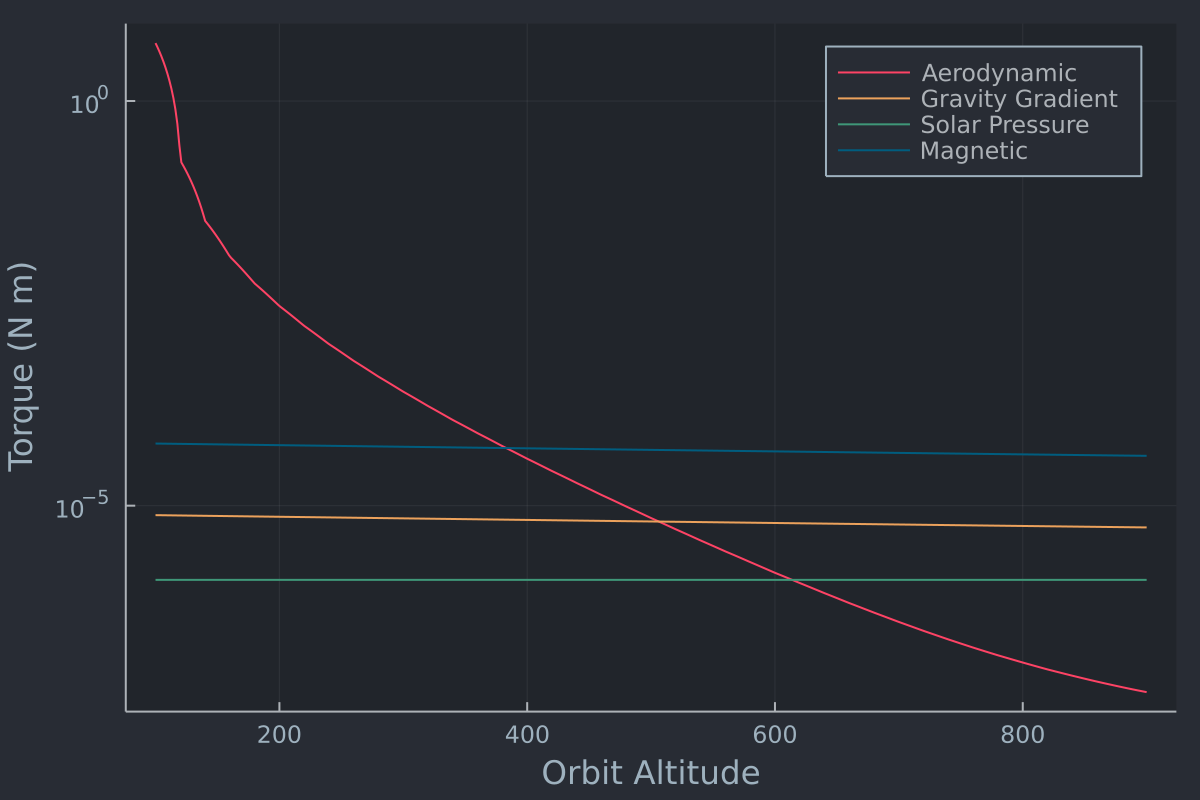

In [120]:
plot(
    orbit_alts, Ta, 
    yaxis=:log, 
    label="Aerodynamic",
    xlabel="Orbit Altitude",
    ylabel="Torque (N m)",
    format=:png,
    dpi=200
)

plot!(orbit_alts, Tg, label="Gravity Gradient")
plot!([orbit_alts[1], orbit_alts[end]], [Tsp, Tsp], label="Solar Pressure")
plot!(orbit_alts, Tm, label="Magnetic")

In [108]:
# getting max disturbance torques
max_torques = []

for i in 1:length(orbit_alts)
    push!(max_torques, maximum([Ta[i], Tm[i]]))
end

In [112]:
# getting required reaction wheel sizing
orbit_periods = (2*π / sqrt(μ)) .* (re .+ orbit_alts).^(3/2)
hw = 0.707 .* max_torques .* orbit_periods ./ 4;

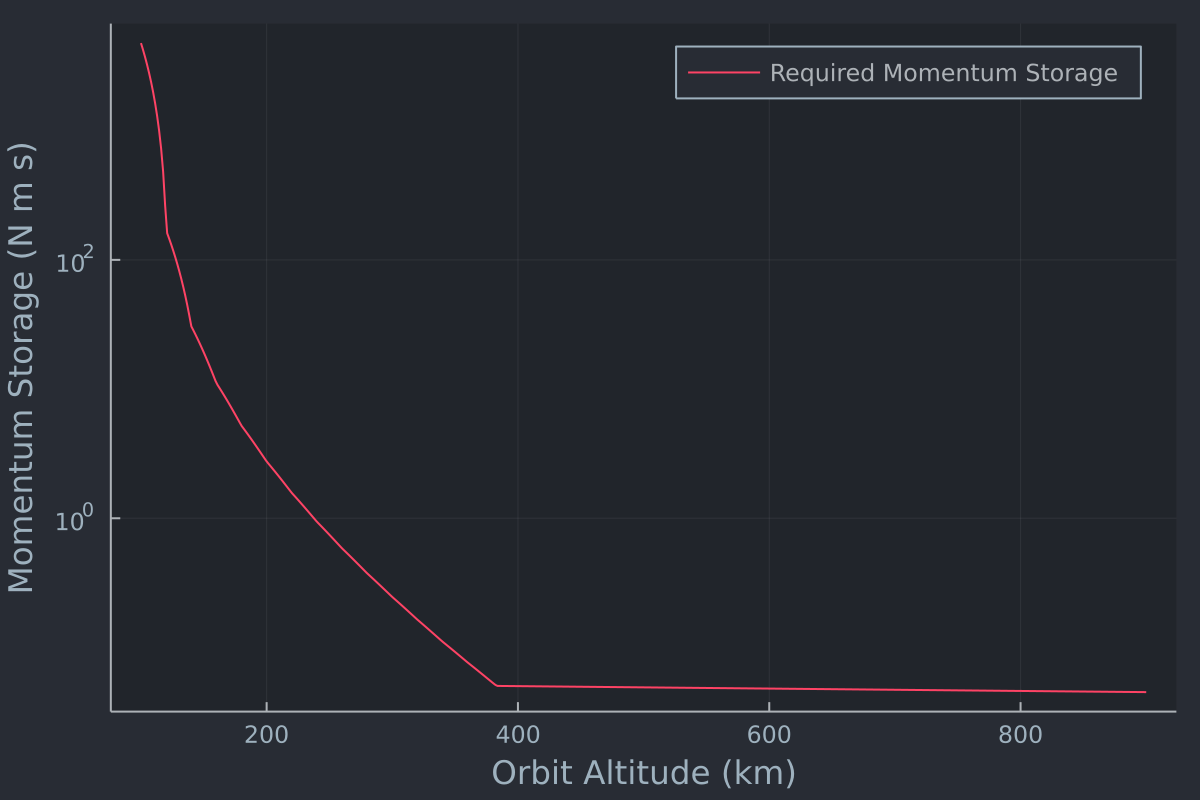

In [121]:
plot(
    orbit_alts, hw, 
    yaxis=:log, 
    label="Required Momentum Storage",
    xlabel="Orbit Altitude (km)",
    ylabel="Momentum Storage (N m s)",
    format=:png,
    dpi=200
)